# 041 GDAL: time series : Answers to exercises

#### Exercise 1

We have seen in [040_GDAL_mosaicing_and_masking](040_GDAL_mosaicing_and_masking.ipynb) that you can use `gdal` to creat a GeoTiff format image, for example with:

    g = gdal.Warp(output_name, input_name ,format='GTiff',options=['COMPRESS=LZW'])
    g.FlushCache()

* Convert the `gdal` file `work/stitch_set.vrt` to a more portable GeoTiff file called `work/stitch_set.tif`
* Confirm that this has worked by reading and displaying data from the file

In [4]:
# ANSWER
import gdal

# Convert the `gdal` file `work/stitch_set.vrt` to a 
# more portable GeoTiff file called `work/stitch_set.tif`

# set up the filenames
infile = 'work/stitch_set.vrt'
outfile = 'work/stitch_set.tif'

# convert using gdal.Warp or similar
g = gdal.Warp(outfile, infile ,format='GTiff',options=['COMPRESS=LZW'])
# force write to disk
g.FlushCache()

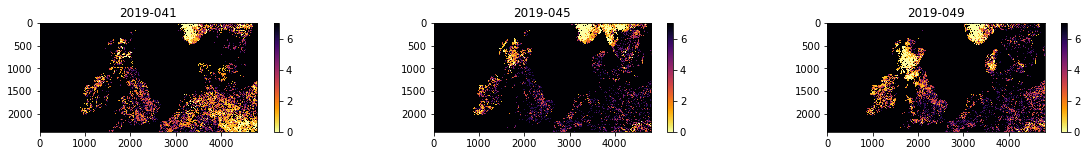

In [5]:
import matplotlib.pyplot as plt
# ANSWER
# Confirm that this has worked by reading and 
# displaying data from the file

# test it by reading and plotting
g = gdal.Open("work/stitch_set.tif")
data = g.ReadAsArray()

fig, axs = plt.subplots(1,3,figsize=(20,2))
axs = axs.flatten()
for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
    fig.colorbar(im, ax=axs[i])
    axs[i].set_title(bnames[i])

#### Exercise 2

* Write a function called `modis_annual_dataset`that takes `year`,`tile` and `product` and `step` and returns a dictionary of appropriate MODIS datasets. 

* Write another function `get_modis_annual` that takes the dictionary of appropriate MODIS datasets. and generates a dictionary of MODIS data values, filtered according to information of the form:

        warp_args = {
            'dstNodata'     : 255,
            'format'        : 'MEM',
            'cropToCutline' : True,
            'cutlineWhere'  : "FIPS='LU'",
            'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
        }

        sds = ['Lai_500m','LaiStdDev_500m','FparLai_QC']

* Write a third function `modis_annual` that combines these two functions.
* Test your code and plot some results

In [19]:
# ANSWER
msg = '''
Write a function called modis_annual_dataset that takes 
year,tile and product and step and  returns a dictionary of appropriate 
MODIS datasets.
'''
import gdal
from geog0111.modis import Modis
import yaml
from pathlib import Path

def modis_annual_dataset(year,tile,product,step=1):
    # load into kwargs
    kwargs = {
    'tile'      :    list(tile),
    'product'   :    product,
    }
    # list of doys we want
    doys = "*"
    '''
    We will gather the data for the year, 
    tiles and product that we are interested in into a VRT file:
    '''
    modis = Modis(**kwargs)
    ifiles = modis.get_modis(year,doys,step=step)
    return ifiles


In [20]:
# ANSWER

msg = '''
Write another function get_modis_annual that 
takes the dictionary of appropriate MODIS datasets. 
and generates a dictionary of MODIS data values, 
filtered according to information of the form:
'''

def get_modis_annual(ifiles,sds=None,warp_args={}):
    # loop over SDS sets and read into dictionary
    mfiles = {'bandnames':ifiles['bandnames']}
    del ifiles['bandnames']
    
    # useful sds default
    if sds == None:
        sds = ifiles.keys()
    
    for s in sds:
        # do this in case we dont need to cut
        if warp_args != {}:
            g = gdal.Warp("",ifiles[s],**warp_args)
            mfiles[s] = g.ReadAsArray()
        else:
            mfiles[s] = ifiles[s]
    return mfiles


In [21]:
# Write a third function modis_annual 
# that combines these two functions.

def modis_annual(year,tile,product,step=1,\
                 sds=None,warp_args={}):
    
    ifiles = modis_annual_dataset(year,tile,product,step=step)
    mfiles = get_modis_annual(ifiles,sds=sds,warp_args=warp_args)
    # what to do is SDS is None?
    return mfiles

In [22]:
# ANSWER : Test

warp_args = {
  'dstNodata'     : 255,
  'format'        : 'MEM',
  'cropToCutline' : True,
  'cutlineWhere'  : "FIPS='LU'",
  'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}
sds     = ['Lai_500m','LaiStdDev_500m','FparLai_QC']
tile    = ['h17v03','h18v03','h17v04','h18v04']
product = 'MCD15A3H'
year    = 2019
step    = 4

mfiles = modis_annual(year,tile,product,sds=sds,step=step,warp_args=warp_args)
print(mfiles.keys())

dict_keys(['bandnames', 'Lai_500m', 'LaiStdDev_500m', 'FparLai_QC'])


#### Exercise 3

* Write a function `get_lai_data` that takes as argument:
    
        year : integer year
        tile : list of tiles to process
        fips : country fips code (e.g. BE for Belgium)
        
  and returns the annual LAI, standard deviation and day of year

* test your code for Belgium for 2018 for tiles `['h17v03','h18v03','h17v04','h18v04']`
* show the shape of the arrays returned

Hint: You may find it useful to use `geog0111.modis_annual`


In [31]:
# ANSWER
from geog0111.modis_annual import modis_annual
import numpy as np

def get_lai_data(year,tile,fips):
    '''
    Get the annual LAI dataset for fips, tile and year
    and return lai,std,doy
    '''
    # load some data
    sds     = ['Lai_500m','LaiStdDev_500m']
    product = 'MCD15A3H'

    warp_args = {
      'dstNodata'     : 255,
      'format'        : 'MEM',
      'cropToCutline' : True,
      'cutlineWhere'  : f"FIPS='{fips}'",
      'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
    }
    
    mfiles = modis_annual(year,tile,product,step=4,\
                          sds=sds,warp_args=warp_args)
    # scale it
    lai = mfiles['Lai_500m'] * 0.1
    std = mfiles['LaiStdDev_500m'] * 0.1
    # doy from filenames
    doy = np.array([int(i.split('-')[1]) for i in mfiles['bandnames']])
    return lai,std,doy

In [32]:
# Test

tile = ['h17v03','h18v03','h17v04','h18v04']
year = 2018
fips = 'BE'
# test your code for Belgium for 2018 for 
# tiles ['h17v03','h18v03','h17v04','h18v04']
lai,std,doy = get_lai_data(year,tile,fips)
print(f'shape of lai: {lai.shape}')
print(f'shape of std: {std.shape}')
print(f'shape of doy: {doy.shape}')

shape of lai: (92, 479, 596)
shape of std: (92, 479, 596)
shape of doy: (92,)
